# Линейная регрессия

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Мы будем работать с датасетом simplicity_DA отсюда: https://github.com/feralvam/metaeval-simplification/tree/main/data. Это датасет ассессорских оценок автоматически упрощенных предложений. В нём эксперты оценивали пары предложений, состоящие из оригинального текста и текста, упрощенного моделью (использовалось несколько различных нейросетевых моделей), по параметрам fluency, meaning и simplicity.

In [ ]:
simplicity_df = pd.read_csv('/content/drive/MyDrive/ML_training_data/simplicity_DA.csv')

Быстро проверим на отсутствующие данные:

In [ ]:
simplicity_df.isnull().values.any()

False

In [ ]:
simplicity_df.head()

,sent_id,sys_name,orig_sent,simp_sent,sys_type,fluency,fluency_zscore,meaning,meaning_zscore,simplicity,simplicity_zscore
0,268,ACCESS,Prunk is a member of Institute of European His...,Prunk is a member of Institute of European His...,NeuralSeq2Seq,77.400000,0.152400,77.333333,0.530362,71.333333,0.611060
1,67,SBMT-SARI,"In return, Rollo swore fealty to Charles, conv...","In return, Rollo swore fealty to Charles, conv...",SBMT,87.866667,0.512595,96.466667,1.142803,90.933333,1.257177
2,341,SBMT-SARI,From 1900 to 1920 many new facilities were con...,From 1900 to 1920 many new plants were built o...,SBMT,79.133333,0.119438,68.533333,0.284701,53.800000,0.158894
3,278,PBMT-R,Mercury is similar in appearance to the Moon: ...,Mercury is similar in appearance to the Moon: ...,PBMT,90.333333,0.598145,90.666667,0.965649,71.600000,0.664848
4,107,Hybrid,"He settled in London, devoting himself chiefly...","He settled in London, devoting himself.",Semantics+PBMT,65.466667,-0.425792,32.066667,-0.820035,27.733333,-0.577387


Давайте для начала попробуем предсказать простоту предложения (simplicity), ориентируясь на meaning preservation (meaning) - то, насколько хорошо модель сохранила значение исходного предложения.

In [ ]:
from sklearn.model_selection import train_test_split

В данном случае наша зависимая переменная - simplicity, а независимая - meaning.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(simplicity_df['meaning'],
                                                    simplicity_df['simplicity'],
                                                    test_size=0.2,
                                                    random_state=42
                                                    )

Обучим линейную регрессию на тренировочной выборке.

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
lr = LinearRegression()

In [ ]:
lr.fit(X_train, y_train)

ValueError: Expected a 2-dimensional container but got <class 'pandas.core.series.Series'> instead. Pass a DataFrame containing a single row (i.e. single sample) or a single column (i.e. single feature) instead.

Принимать одну колонку типа pandas.Series линейная регрессия не захочет, поэтому мы преобразуем наши признаки в numpy.array формы (n_features, 1). Зависимую переменную можно просто сделать списком.

In [ ]:
X_train_numpy = np.array(X_train)

In [ ]:
X_train_numpy.shape

(480,)

In [ ]:
X_train_reshaped = X_train_numpy.reshape(-1, 1)

In [ ]:
X_train_reshaped.shape

(480, 1)

In [ ]:
lr.fit(X_train_reshaped, y_train.tolist())

LinearRegression()

Чтобы оценить качество регрессии, испытаем ее на тестовых данных.

In [ ]:
X_test_numpy = np.array(X_test)
X_test_reshaped = X_test_numpy.reshape(-1, 1)

y_pred = lr.predict(X_test_reshaped)

Загрузим метрики для оценки: $ R^2 $ и среднеквадратичную ошибку:

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
# %.2f округляет значения float до двух знаков после запятой
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
print("R squared: %.2f" % r2_score(y_test, y_pred))

Mean squared error: 169.60
R squared: 0.61


Коэффициенты и intercept можно найти в атрибутах модели:

In [ ]:
lr.coef_

array([0.67981516])

In [ ]:
lr.intercept_

9.282809418314542

Попробуем отрисовать получившуюся регрессию.

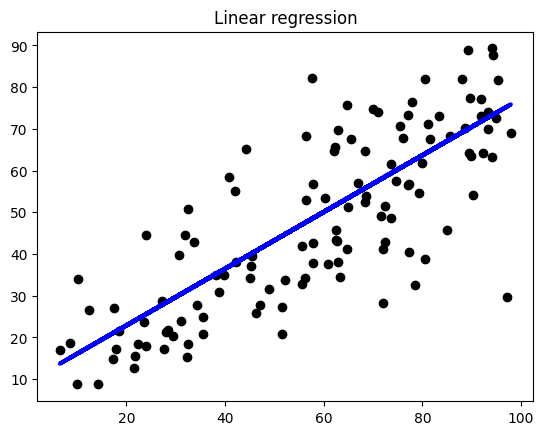

In [ ]:
plt.scatter(X_test, y_test, color="black")
plt.plot(X_test, y_pred, color="blue", linewidth=3)

plt.xticks()
plt.yticks()
plt.title('Linear regression')

plt.show()

Еще несколько метрик, которые можно использовать для оценки:

In [ ]:
from sklearn.metrics import explained_variance_score, mean_absolute_error

explained_variance = explained_variance_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print('Explained variance: %.2f' % explained_variance)
print('Mean absolute error: %.2f' % mae)

Explained variance: 0.62
Mean absolute error: 10.47


PredictionErrorDisplay - это график, в котором по оси х обозначены предсказанные значения, а по оси у - residuals, т.е. разница между предсказанным значением и настоящим.

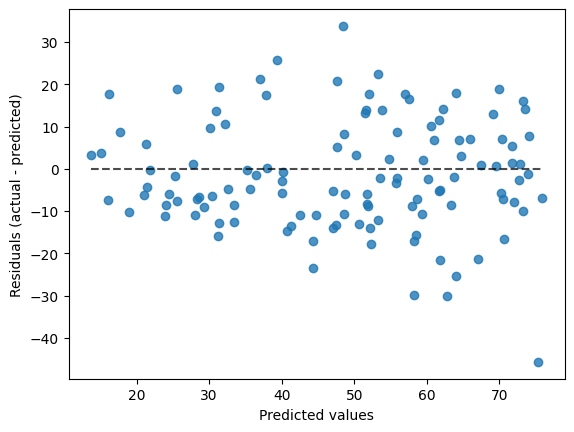

In [ ]:
from sklearn.metrics import PredictionErrorDisplay

display = PredictionErrorDisplay(y_true=y_test, y_pred=y_pred)
display.plot()
plt.show()

# K Nearest Neighbors

На прошлом занятии мы с вами обсуждали, что алгоритм k ближайших соседей используется как для регрессии, так и для классификации. Давайте попробуем самостоятельно реализовать этот алгоритм для задачи регрессии. (Это пример из лекции Ильи Щурова: https://github.com/ischurov/math-ml-hse-2018/blob/master/sem03_knn/sem03_knn.ipynb)

Предположим, что у нас есть некий набор признаков X и зависимая переменная y:

In [ ]:
X = np.array([[0, 1, 1], [1, 0, 1], [1, 1, 1]])
y = np.array([0, 1, 2])

Мы хотим найти y для нового вектора X_new.

In [ ]:
X_new = np.array([0, 0, 1])

Для этого, согласно алгоритму k ближайших соседей, нам нужно найти, к какому из векторов тренировочной выборки новый вектор ближе всего. Расстояние между векторами обозначается через норму разностей этих векторов (больше про сравнение векторов здесь: https://dzen.ru/a/XEguZJw2sACu7e8l):

In [ ]:
X - X_new

array([[0, 1, 0],
       [1, 0, 0],
       [1, 1, 0]])

In [ ]:
diff = np.linalg.norm(X - X_new, axis=1)

In [ ]:
diff

array([1.        , 1.        , 1.41421356])

np.argsort сортирует массив от малого к большому и возвращает соответствующий массив **индексов**.

In [ ]:
sorted_ = np.argsort(diff)

In [ ]:
sorted_

array([0, 1, 2])

Итак, мы отсортировали тренировочные вектора по близости к новому. Как сделать предсказание?

Помним, что мы должны выбрать k ближайших векторов к новому. Примем k = 2. Тогда возьмем эти два вектора и усредним их значения y, чтобы получить y_pred для нового вектора:

In [ ]:
k = 2
# берем первые k элементов y_train и усредняем
y_pred = y[sorted_[:k]].mean()

In [ ]:
y_pred

0.5

Напишем свой собственный класс:

In [ ]:
class DummyKNNRegression():

  def __init__(self, n_neighbors):
    self.n_neighbors = n_neighbors

  def fit(self, X_train, y_train):
    self.X = X_train
    self.y = y_train

  def predict(self, X_new_matrix):
    # на вход в функцию predict будет поступать не один новый вектор, а сразу много
    # так что функционал реализуем соответствующий
    y_pred_list = []

    for X_new in X_new_matrix:
      diff = np.linalg.norm(self.X - X_new, axis=1)
      sorted_ = np.argsort(diff)
      y_pred = self.y[sorted_[:self.n_neighbors]].mean()
      y_pred_list.append(y_pred)

    return y_pred_list

**Вопрос:** как превратить это в классификацию?

In [ ]:
dummy_knn = DummyKNNRegression(n_neighbors=2)

In [ ]:
dummy_knn.fit(X, y)

In [ ]:
dummy_knn.predict([X_new])

[0.5]

In [ ]:
dummy_knn.X

array([[0, 1, 1],
       [1, 0, 1],
       [1, 1, 1]])

Применим наш класс для моделирования зависимости простоты от сохранения смысла:

In [ ]:
dummy_knn_for_sim = DummyKNNRegression(n_neighbors=5)

In [ ]:
dummy_knn_for_sim.fit(np.array(X_train).reshape(-1, 1), np.array(y_train))

In [ ]:
y_pred_sim = dummy_knn_for_sim.predict(np.array(X_test).reshape(-1, 1))

In [ ]:
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred_sim))
print("R squared: %.2f" % r2_score(y_test, y_pred_sim))

Mean squared error: 209.14
R squared: 0.52


Теперь посмотрим, как настоящий KNN-регрессор из sklearn работает на наших данных:

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

In [ ]:
knn = KNeighborsRegressor(n_neighbors=5, weights='uniform')

In [ ]:
knn.fit(np.array(X_train).reshape(-1, 1), np.array(y_train))

KNeighborsRegressor()

In [ ]:
y_pred_knn = knn.predict(np.array(X_test).reshape(-1, 1))

In [ ]:
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred_knn))
print("R squared: %.2f" % r2_score(y_test, y_pred_knn))

Mean squared error: 197.41
R squared: 0.55


# Регрессии на датасете California Housing

In [ ]:
from sklearn.datasets import fetch_california_housing

In [ ]:
housing = fetch_california_housing()

In [ ]:
housing

{'data': array([[   8.3252    ,   41.        ,    6.98412698, ...,    2.55555556,
           37.88      , -122.23      ],
        [   8.3014    ,   21.        ,    6.23813708, ...,    2.10984183,
           37.86      , -122.22      ],
        [   7.2574    ,   52.        ,    8.28813559, ...,    2.80225989,
           37.85      , -122.24      ],
        ...,
        [   1.7       ,   17.        ,    5.20554273, ...,    2.3256351 ,
           39.43      , -121.22      ],
        [   1.8672    ,   18.        ,    5.32951289, ...,    2.12320917,
           39.43      , -121.32      ],
        [   2.3886    ,   16.        ,    5.25471698, ...,    2.61698113,
           39.37      , -121.24      ]]),
 'target': array([4.526, 3.585, 3.521, ..., 0.923, 0.847, 0.894]),
 'frame': None,
 'target_names': ['MedHouseVal'],
 'feature_names': ['MedInc',
  'HouseAge',
  'AveRooms',
  'AveBedrms',
  'Population',
  'AveOccup',
  'Latitude',
  'Longitude'],
 'DESCR': '.. _california_housing_dataset:\n

In [ ]:
housing.data

array([[   8.3252    ,   41.        ,    6.98412698, ...,    2.55555556,
          37.88      , -122.23      ],
       [   8.3014    ,   21.        ,    6.23813708, ...,    2.10984183,
          37.86      , -122.22      ],
       [   7.2574    ,   52.        ,    8.28813559, ...,    2.80225989,
          37.85      , -122.24      ],
       ...,
       [   1.7       ,   17.        ,    5.20554273, ...,    2.3256351 ,
          39.43      , -121.22      ],
       [   1.8672    ,   18.        ,    5.32951289, ...,    2.12320917,
          39.43      , -121.32      ],
       [   2.3886    ,   16.        ,    5.25471698, ...,    2.61698113,
          39.37      , -121.24      ]])

In [ ]:
housing.target.shape

(20640,)

In [ ]:
housing.feature_names

['MedInc',
 'HouseAge',
 'AveRooms',
 'AveBedrms',
 'Population',
 'AveOccup',
 'Latitude',
 'Longitude']

In [ ]:
df = pd.DataFrame(housing.data, columns=housing.feature_names)

In [ ]:
df['Value'] = housing.target

In [ ]:
df

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Value
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
...,...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847


array([[<Axes: title={'center': 'MedInc'}>,
        <Axes: title={'center': 'HouseAge'}>,
        <Axes: title={'center': 'AveRooms'}>],
       [<Axes: title={'center': 'AveBedrms'}>,
        <Axes: title={'center': 'Population'}>,
        <Axes: title={'center': 'AveOccup'}>],
       [<Axes: title={'center': 'Latitude'}>,
        <Axes: title={'center': 'Longitude'}>,
        <Axes: title={'center': 'Value'}>]], dtype=object)

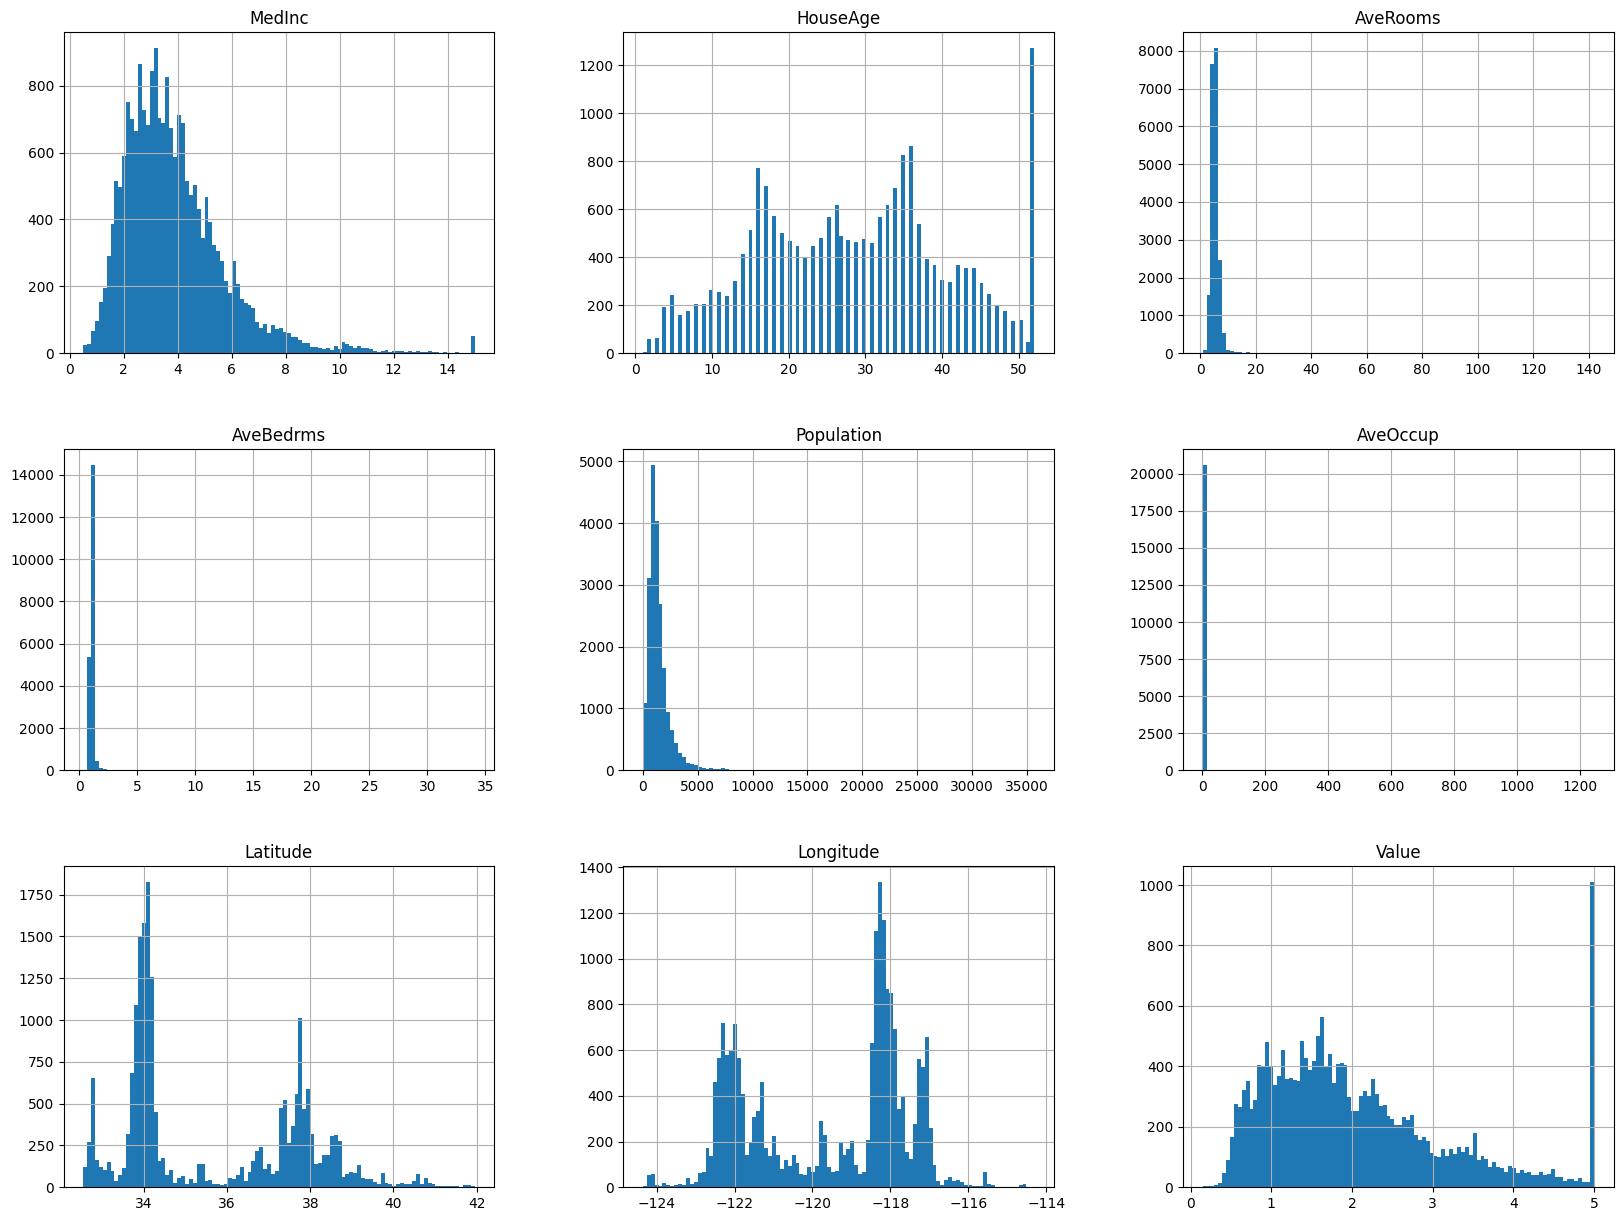

In [ ]:
df.hist(bins=100, figsize=(20,15))

In [ ]:
from scipy.stats import zscore

In [ ]:
THRESHOLD_HIGH = 3
THRESHOLD_LOW = -3

In [ ]:
from collections import defaultdict

In [ ]:
zscore_dict = defaultdict(list)

for col in df.columns:
    current_zscore = zscore(df[col])
    zscore_dict[col] = current_zscore

In [ ]:
zscore_df = pd.DataFrame(zscore_dict)

In [ ]:
zscore_df

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Value
0,2.344766,0.982143,0.628559,-0.153758,-0.974429,-0.049597,1.052548,-1.327835,2.129631
1,2.332238,-0.607019,0.327041,-0.263336,0.861439,-0.092512,1.043185,-1.322844,1.314156
2,1.782699,1.856182,1.155620,-0.049016,-0.820777,-0.025843,1.038503,-1.332827,1.258693
3,0.932968,1.856182,0.156966,-0.049833,-0.766028,-0.050329,1.038503,-1.337818,1.165100
4,-0.012881,1.856182,0.344711,-0.032906,-0.759847,-0.085616,1.038503,-1.337818,1.172900
...,...,...,...,...,...,...,...,...,...
20635,-1.216128,-0.289187,-0.155023,0.077354,-0.512592,-0.049110,1.801647,-0.758826,-1.115804
20636,-0.691593,-0.845393,0.276881,0.462365,-0.944405,0.005021,1.806329,-0.818722,-1.124470
20637,-1.142593,-0.924851,-0.090318,0.049414,-0.369537,-0.071735,1.778237,-0.823713,-0.992746
20638,-1.054583,-0.845393,-0.040211,0.158778,-0.604429,-0.091225,1.778237,-0.873626,-1.058608


In [ ]:
zscore_df[zscore_df[zscore_df >= THRESHOLD_HIGH].any(axis=1)]

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Value
131,4.069443,-0.845393,1.174583,-0.029966,-0.788104,-0.031123,1.033821,-1.307870,1.609668
283,1.112883,-0.527561,0.444492,-0.117104,3.143248,-0.051642,1.010411,-1.292896,1.422482
409,3.269770,1.856182,1.123642,-0.152110,-0.677723,-0.036004,1.061912,-1.352792,1.647799
510,4.205564,0.823227,1.003233,-0.237494,-0.545265,-0.048680,1.024457,-1.322844,2.540411
511,5.068140,1.061601,1.414389,-0.203999,-0.359824,-0.003067,1.024457,-1.322844,2.540411
...,...,...,...,...,...,...,...,...,...
20529,-0.479094,-1.322142,-0.207613,-0.156625,3.715467,-0.041976,1.366233,-1.103226,-0.022149
20530,-0.386136,-1.401600,-0.145012,-0.171229,5.791525,-0.036124,1.375597,-1.093244,-0.043814
20544,-0.950465,-0.448103,-0.252820,-0.175204,4.330955,0.037030,1.366233,-1.093244,0.108709
20563,-0.392505,-1.560516,-0.113573,0.048360,4.778663,-0.016481,1.422416,-1.088252,-0.644371


In [ ]:
zscore_df[zscore_df[zscore_df <= THRESHOLD_LOW].any(axis=1)]

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Value


In [ ]:
df_to_remove = zscore_df[zscore_df[zscore_df >= THRESHOLD_HIGH].any(axis=1)]

In [ ]:
df_no_outliers = df.drop(list(df_to_remove.index))

In [ ]:
df_no_outliers

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Value
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
...,...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847


In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
X_train_ch, X_test_ch, y_train_ch, y_test_ch = train_test_split(df_no_outliers.loc[:, df_no_outliers.columns != 'Value'],
                                                                df_no_outliers['Value'],
                                                                test_size=0.2)

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 0.001))

In [ ]:
scaler.fit(X_train_ch)

MinMaxScaler(feature_range=(0, 0.001))

In [ ]:
X_train_scaled = scaler.transform(X_train_ch)
X_test_scaled = scaler.transform(X_test_ch)

In [ ]:
X_train_scaled

array([[2.47079349e-04, 6.86274510e-04, 3.46850084e-04, ...,
        6.13500954e-05, 1.75531915e-04, 6.01642710e-04],
       [1.73693160e-04, 8.03921569e-04, 2.51935149e-04, ...,
        1.15852347e-04, 1.55319149e-04, 6.37577002e-04],
       [3.36995649e-04, 4.50980392e-04, 3.46267295e-04, ...,
        7.62402051e-05, 1.36170213e-04, 6.20123203e-04],
       ...,
       [6.34107021e-04, 1.00000000e-03, 4.71347423e-04, ...,
        4.40584850e-05, 5.67021277e-04, 2.09445585e-04],
       [3.96844151e-04, 6.66666667e-04, 3.96528562e-04, ...,
        9.07963504e-05, 1.67021277e-04, 6.59137577e-04],
       [3.45078510e-04, 4.11764706e-04, 4.31712695e-04, ...,
        5.85928378e-05, 6.21276596e-04, 1.51950719e-04]])

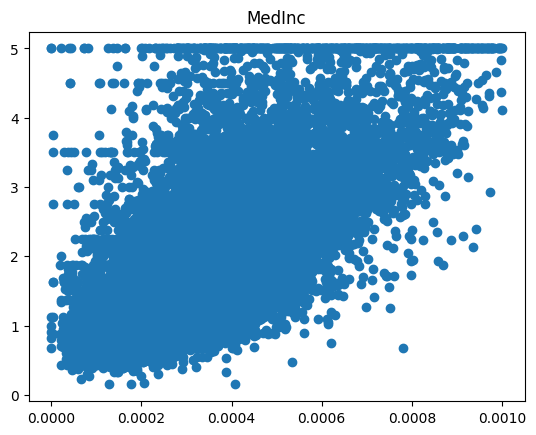

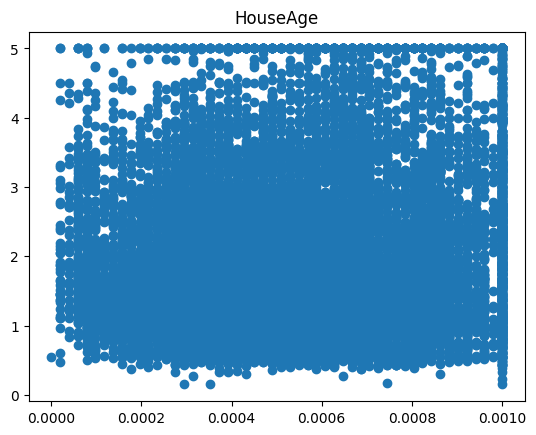

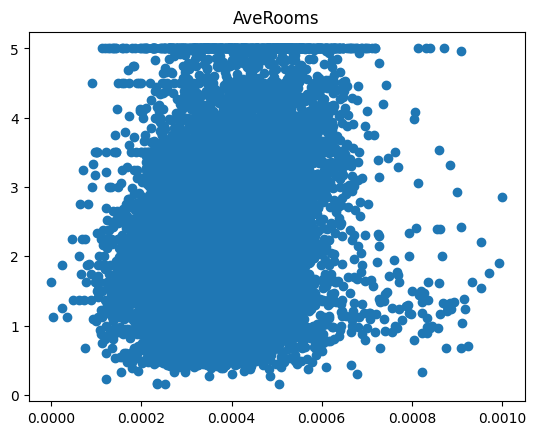

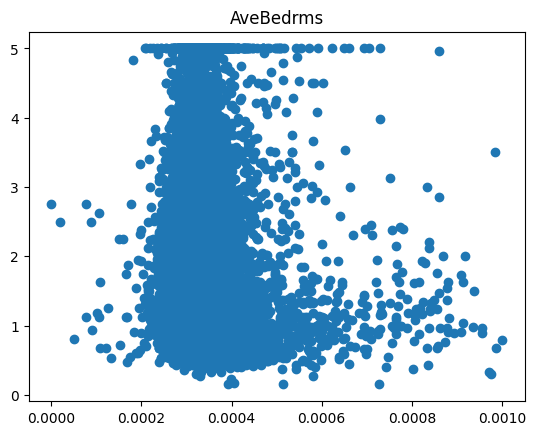

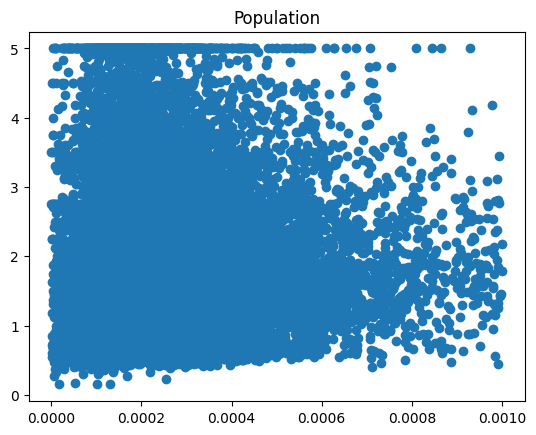

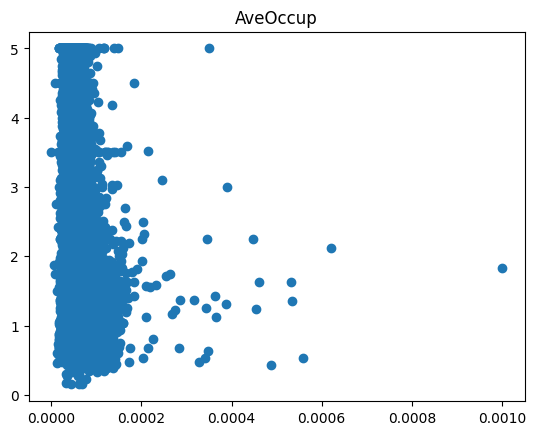

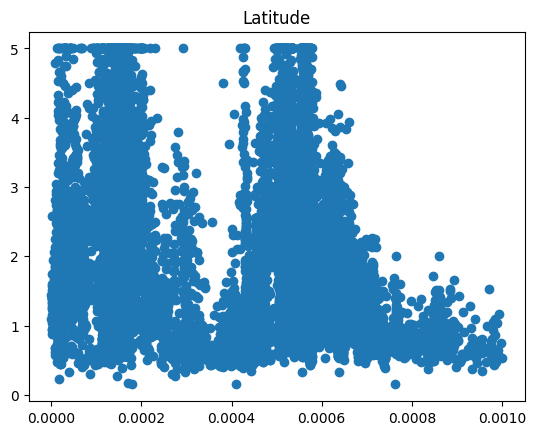

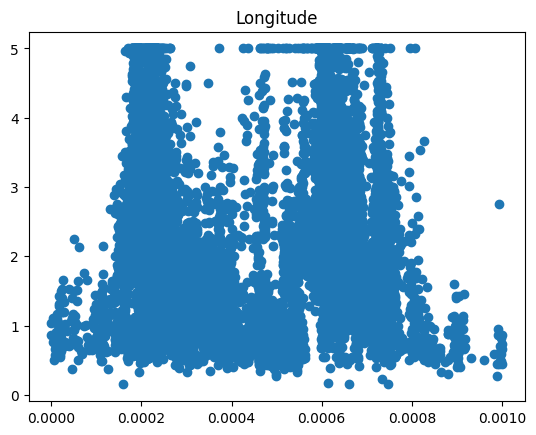

In [ ]:
for i in range(X_train_scaled.shape[1]):
  current_col_name = X_train_ch.columns[i]
  current_X = X_train_scaled[:, i]
  plt.scatter(current_X, y_train_ch)
  plt.title(current_col_name)
  plt.show()

In [ ]:
ln_ch = LinearRegression()

In [ ]:
ln_ch.fit(X_train_scaled, y_train_ch)

LinearRegression()

In [ ]:
ln_ch_pred = ln_ch.predict(X_test_scaled)

In [ ]:
def get_scores(y_test, y_pred):
  print('R^2: %.2f' % r2_score(y_test, y_pred))
  print('MSE: %.2f' % mean_squared_error(y_test, y_pred))
  print('MAE: %.2f' % mean_absolute_error(y_test, y_pred))

In [ ]:
get_scores(y_test_ch, ln_ch_pred)

R^2: 0.63
MSE: 0.47
MAE: 0.50


In [ ]:
from sklearn.linear_model import Ridge, Lasso

In [ ]:
lasso = Lasso()

In [ ]:
lasso.fit(X_train_scaled, y_train_ch)

Lasso()

In [ ]:
lasso_pred = lasso.predict(X_test_scaled)

In [ ]:
get_scores(y_test_ch, lasso_pred)

R^2: -0.00
MSE: 1.26
MAE: 0.88


In [ ]:
lasso.coef_

array([ 0.,  0.,  0., -0., -0., -0., -0., -0.])

In [ ]:
ridge = Ridge(alpha=0.001)

In [ ]:
ridge.fit(X_train_scaled, y_train_ch)
ridge_pred = ridge.predict(X_test_scaled)

In [ ]:
get_scores(y_test_ch, ridge_pred)

R^2: 0.27
MSE: 0.91
MAE: 0.74


In [ ]:
from sklearn.preprocessing import PolynomialFeatures

In [ ]:
poly = PolynomialFeatures(2)

In [ ]:
poly.fit(X_train_scaled)

PolynomialFeatures()

In [ ]:
X_train_poly = poly.transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)

In [ ]:
ln_poly = LinearRegression()

In [ ]:
ln_poly.fit(X_train_poly, y_train_ch)

LinearRegression()

In [ ]:
preds_poly = ln_poly.predict(X_test_poly)

In [ ]:
get_scores(y_test_ch, preds_poly)

R^2: 0.69
MSE: 0.38
MAE: 0.43
